In [1]:
%reload_ext lab_black

# Visualization of Communities via the Road Network

## Introduction
 This is the re-creation of an earlier blog post, except this time I am going straight from
 my Jupyter Notebook to a HTML blog post, rather than handcrafting the Markdown text,
 interspersed with snippets of cut-and-paste code.  I will be using the ```lab_black``` extension to format
 the Python automatically.
 
 Having extracted the local road network from Open Street Maps (via OSMNX - see earlier blog posts), I thought it might be interesting to checkout what properties of the road network we could automatically extract. One such property is that of 'community'.

## Data Sources
To provide continuity with the previous maps, I included the local police stations.
The source of the police station locations is https://data.qld.gov.au/dataset/qps-police-stations

## Mapping Design
Because I wanted to underlay some geographic context to the visualization of the road network, 
I decided to go with Cartopy as the basic mapping software, as its support for inclusion of map tiles is excellent.

In order to provide some context, 
I decided to use Cartopy to underlay the Stamen image tiles, 
showing just terrain. The URL is http://tile.stamen.com/terrain-background

This also proves a nice (and accurate) coastline, without which the map would be a little confusing.

As before, I chose OSMNX for road information, as it is unsurpassed in this area.

## Implementation
### Imports
For completeness, here are the imports for this Jupyter Notebook (not all are used in the code fragments above, as some are for producing output to support reproducability).

In [2]:
import osmnx as ox
import networkx as nx
from networkx.algorithms import community

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mpc
import matplotlib.cm as mcm

import cartopy.crs as ccrs
from cartopy.mpl.gridliner import (
    LONGITUDE_FORMATTER,
    LATITUDE_FORMATTER,
)
from cartopy.io.img_tiles import GoogleTiles

from shapely.geometry import Polygon
from shapely.geometry import LineString

import itertools

# show info to support reproducability
import sys
import os
import subprocess
import datetime
import platform

### Magic commands

Here we specify we want graphics produced inline.

In [3]:
%matplotlib inline

### Background Map Tiles
The Stamen terrain-only background map tiles are not supported out-of-box by Cartopy, but it is pretty easy to get access to them.

The following code fragment gets us an imagery map tile provider that we can pass to Cartopy.

In [4]:
class StamenToner(GoogleTiles):
    def _image_url(self, tile):
        x, y, z = tile
        url = 'http://tile.stamen.com/terrain-background/{}/{}/{}.png'.format(
            z, x, y
        )
        return url

    # end _image_url


# end StamenToner

imagery = StamenToner()

### Constructing the map

#### Creating the figure
First we create a figure holding a map, that uses the PlateCarree coordinate refrence system (CRS). Next, we set the extent of our map (to be just my local area).


Next we load the road network, and convert the nodes (intersections) and edges (road segments) of our graph into GeoPandas GeoDataFrames.

Next we add the background image, and plot the road network. We set ```zorder``` to 2, so that all the roads are visible, even when we add our community shading.

#### Extracting the communities
Next, we add an attribute community to our GeoDataFrame that represents nodes, and set it to 0 for all nodes.

Then we use an algorithm provided by networkx. I tried most of the networkx community algorithms: some took to long to complete, some failed on the types of network (graphs) returned by OSMNX, but ```async_fluidc```:

* gave results that accorded with my intuition,
* was reasonably snappy

Note that the networks returned via OSMNX must be converted to undirected network before processing. I chose to extract 8 communities; this was an arbitary guess, but as it turns out, not a bad one given the size of the area in my map.

The async_fluidc call returns sets of nodes; each node in the set belong to the same community. We loop over these sets, and assign an integer to each node, being the community index (starting at 1 for non-programmer friendliness)

#### Plotting the communities

We show the communities by usng GeoPandas to draw the nodes, with a marker colored according to the ```community``` attribute. I decided to use the ```Set3``` colormap.

#### Map Embellishments
I add:
- a marker for my home
- add markers for local police stations
- a grid
- a title,

and show the result.

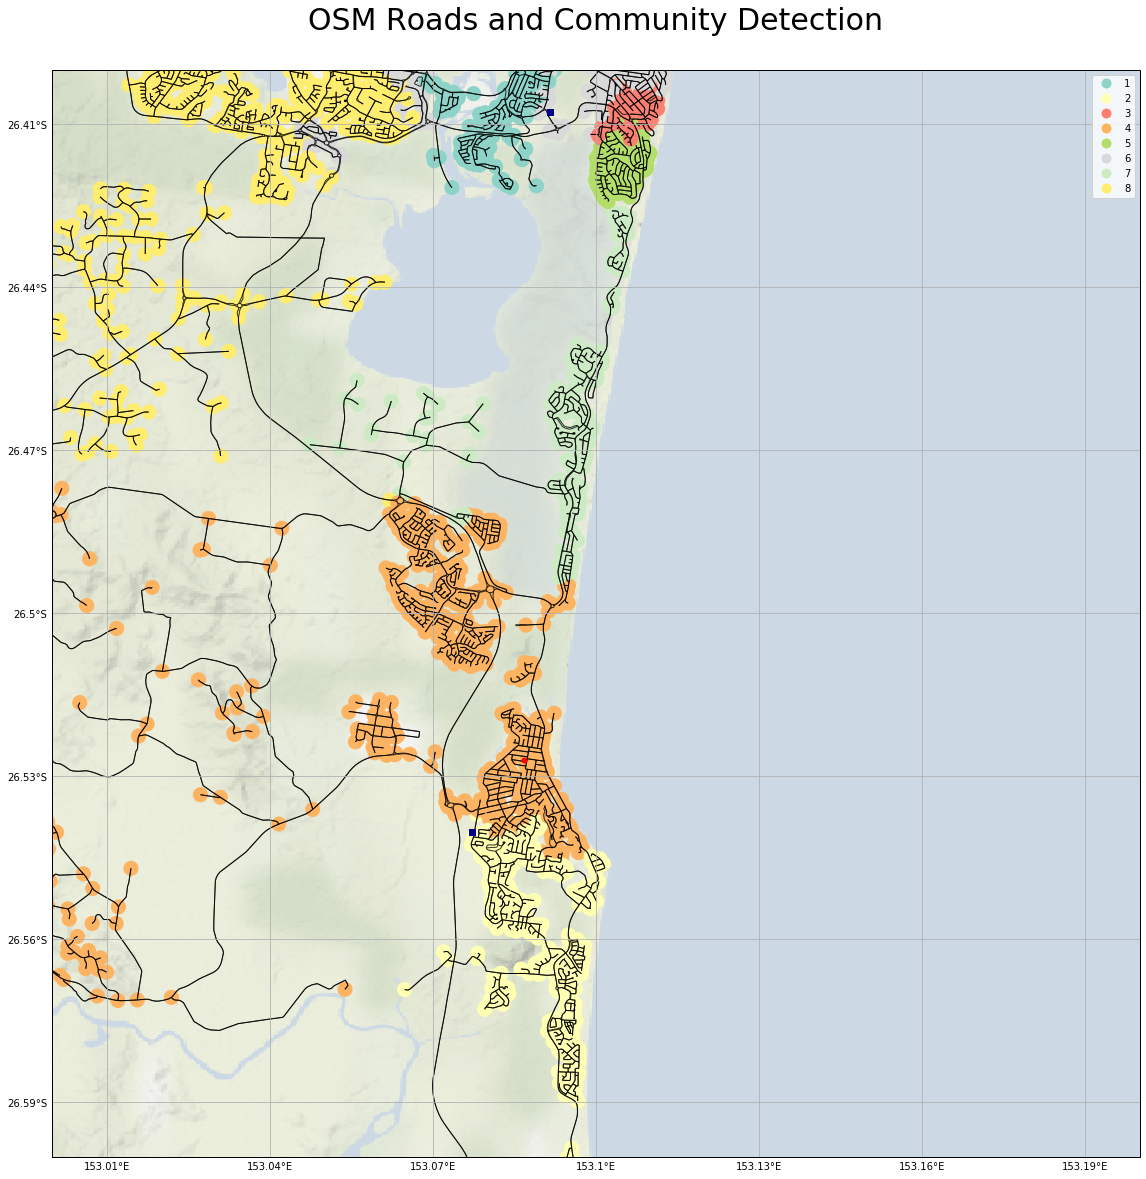

In [5]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

home = (
    153,
    153.2,
    -26.6,
    -26.4,
)  # home = ( 152.5, 153.5, -27, -26)
ax.set_extent(home, crs=ccrs.PlateCarree())

graph = ox.graph_from_bbox(
    home[3],
    home[2],
    home[1],
    home[0],
    network_type="drive",
    truncate_by_edge=True,
)
n_df, e_df = ox.save_load.graph_to_gdfs(
    graph, nodes=True, edges=True
)

ax.add_image(imagery, 12, alpha=0.5)
e_df.plot(
    ax=ax,
    edgecolor="black",
    linewidth=1,
    facecolor="none",
    zorder=2,
    alpha=0.8,
)


n_df["community"] = 0
zz = community.asyn_fluidc(graph.to_undirected(), 8)
for i, x in enumerate(zz):
    for n in x:
        n_df.at[n, "community"] = i + 1
    # end for
# end for

n_df.plot(
    ax=ax,
    marker="o",
    markersize=200,
    column="community",
    cmap="Set3",
    zorder=1,
    legend=True,
    categorical=True,
)

# plot marker with lon / lat
home_lat, home_lon = -26.527, 153.08679
ax.plot(
    home_lon,
    home_lat,
    marker="o",
    transform=ccrs.PlateCarree(),
    markersize=5,
    alpha=1,
    color="red",
    zorder=5,
)

station_file = 'D:\\Cartography\\QPS_STATIONS.shp'
police_df = gpd.read_file(station_file)
police_df.plot(
    ax=ax,
    marker="s",
    color="darkblue",
    zorder=5,
    legend=True,
)

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top = gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.title(
    "OSM Roads and Community Detection",
    {"fontsize": 30},
    pad=40,
)

plt.show()

This accords pretty well with my perception of the local communities. The number of communities I chose to extract (8) is maybe a little large, as community 6 (light grey) is probably not real. The differences between the coastal communities (1 - teal, 2 - pink, 8 - dark yellow), and the hinterland community (4 - orange) are very real in real life.

## Reproducibility

The output below shows the environment in which this example was run

In [6]:
theNotebook = "Communities.ipynb"


def python_env_name():
    '''
    python_env_name: returns the conda environment in which the execution is running
    
    Parameters:
    None
    
    Returns:
    A string holding the current environment name
    '''
    envs = subprocess.check_output(
        "conda env list"
    ).splitlines()
    # get unicode version of binary subprocess output
    envu = [x.decode("ascii") for x in envs]
    active_env = list(
        filter(lambda s: "*" in str(s), envu)
    )[0]
    env_name = str(active_env).split()[0]
    return env_name


# end python_env_name


# end python_env_name

print("python version : " + sys.version)
print("python environment :", python_env_name())
print("osxmn version : " + ox.__version__)

print("current wkg dir: " + os.getcwd())
print("Notebook name: " + theNotebook)
print(
    "Notebook run at: "
    + str(datetime.datetime.now())
    + " local time"
)
print(
    "Notebook run at: "
    + str(datetime.datetime.utcnow())
    + " UTC"
)
print("Notebook run on: " + platform.platform())

python version : 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
python environment : ac5-py37
osxmn version : 0.10
current wkg dir: C:\Users\donrc\Documents\JupyterNotebooks\OSMNXNotebookProject\develop
Notebook name: Communities.ipynb
Notebook run at: 2019-08-05 20:22:23.003644 local time
Notebook run at: 2019-08-05 10:22:23.003644 UTC
Notebook run on: Windows-10-10.0.18362-SP0
